In [1]:
import numpy as np
import pandas as pd
from collections import Counter

import matplotlib.pyplot as plt
import plotly.graph_objects as go

import torch

from sklearn.cluster import KMeans

import umap
from sklearn.manifold import TSNE

2024-04-03 16:05:58.772051: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
audio = pd.read_csv("../data/audio.csv")

def list_to_tensor(lst):
    if lst is not None:
        return torch.tensor([float(x) for x in lst.strip("[]").split(",") if x])
    else:
        return None

# Convert the 'latent_audio' column back to tensors
audio['latent_audio'] = audio['latent_audio'].apply(lambda x: list_to_tensor(x) if pd.notnull(x) else None)

In [3]:
def plot_embeddings_interactive(embeddings, df, target_album=None, target_bucket=None):
    """
    This is a function so we can see if there are patterns among different buckets of billboard scores.
    It's a bit dizzying to look at everything overlaid...

    This plot is interactive to make encoding EDA not as painful
    """
    unique_albums = df['album_name'].unique()
    album_colors = plt.cm.rainbow(np.linspace(0, 1, len(unique_albums)))
    album_color_map = {album: f'rgb({int(col[0]*255)}, {int(col[1]*255)}, {int(col[2]*255)})' for album, col in zip(unique_albums, album_colors)}

    s = "cluster_assignment"
    unique_buckets = df[s].unique()
    peak_pos_colors = plt.cm.Spectral(np.linspace(0, 1, len(unique_buckets)))
    peak_pos_color_map = {bucket: f'rgb({int(col[0]*255)}, {int(col[1]*255)}, {int(col[2]*255)})' for bucket, col in zip(unique_buckets, peak_pos_colors)}

    fig = go.Figure()

    # Ensuring embeddings_2d is a NumPy array for indexing
    embeddings_2d_np = np.array(embeddings)

    # Add traces for album names
    for album in unique_albums:
        if target_album is not None and target_album != album:
            continue
        idx = df['album_name'] == album
        selected_embeddings = embeddings_2d_np[idx]
        fig.add_trace(go.Scatter(x=selected_embeddings[:, 0], y=selected_embeddings[:, 1],
                                 mode='markers', marker=dict(color=album_color_map[album], opacity=0.7 if target_album is None or target_album == album else 0.2),
                                 name=album, text=df[idx]['track_name']))

    # Add traces for peak position buckets, set to be initially hidden (visible on legend click)
    for bucket in unique_buckets:
        if target_bucket is not None and target_bucket != bucket:
            continue
        idx = df[s] == bucket
        selected_embeddings = embeddings_2d_np[idx]
        fig.add_trace(go.Scatter(x=selected_embeddings[:, 0], y=selected_embeddings[:, 1],
                                 mode='markers', marker=dict(color=peak_pos_color_map[bucket], opacity=0.7 if target_bucket is None or target_bucket == bucket else 0.2),
                                 name=str(bucket), text=df[idx]['track_name'],
                                 visible='legendonly'))

    fig.update_layout(title='Interactive Plot of Song Embeddings',
                      xaxis_title='TSNE 1',
                      yaxis_title='TSNE 2',
                      legend_title_text='Legend',
                      hovermode='closest')

    fig.show()

In [4]:
embedding_dim = 768
embeddings = np.array([embedding.flatten() if embedding is not None else np.zeros(embedding_dim) for embedding in audio['latent_audio']])

In [5]:
ndims = 40
umap_reducer = umap.UMAP(n_components=ndims, random_state=256)
reduced_UMAP = umap_reducer.fit_transform(embeddings)

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/umap/umap_.py:1943: UserWarning: n_jobs value -1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


In [6]:
# Reducing with TSNE down to two dimensions to see if we can visually assess any separation?
tsne = TSNE(n_components=2, random_state=256)
embeddings_tsne_2d = tsne.fit_transform(reduced_UMAP)

plot_embeddings_interactive(embeddings_tsne_2d, audio)

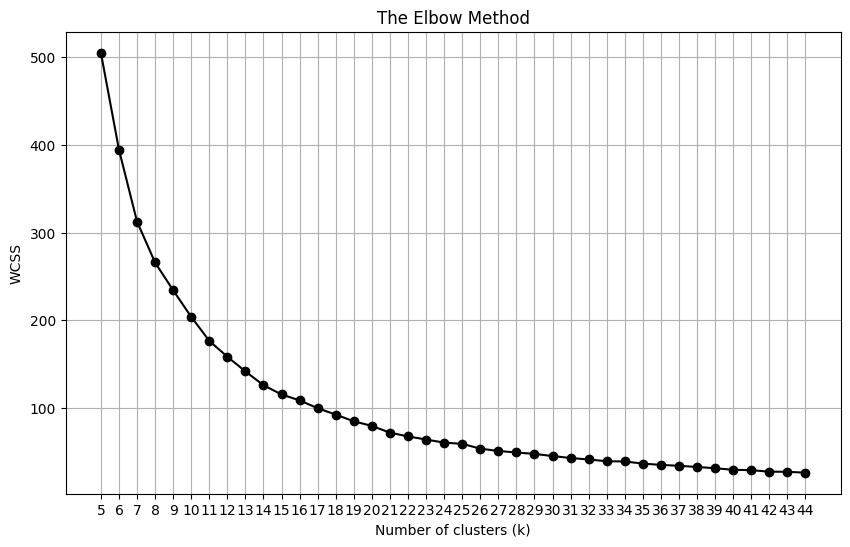

In [7]:
k_values = range(5, 45) 
wcss = []

for k in k_values:
    kmeans = KMeans(n_clusters=k, random_state=256, n_init=10)
    kmeans.fit(reduced_UMAP)
    wcss.append(kmeans.inertia_)

# Plotting the results
plt.figure(figsize=(10, 6))
plt.plot(k_values, wcss, '-o', color='black')
plt.title('The Elbow Method')
plt.xlabel('Number of clusters (k)')
plt.ylabel('WCSS')
plt.xticks(k_values)
plt.grid(True)
plt.show()

In [8]:
k = 15
kmeans = KMeans(n_clusters=k, random_state=256, n_init=10).fit(embeddings)
audio['cluster_assignment'] = kmeans.labels_

Cluster 0: 42 members (12.84%)
Cluster 1: 37 members (11.31%)
Cluster 2: 8 members (2.45%)
Cluster 3: 7 members (2.14%)
Cluster 4: 14 members (4.28%)
Cluster 5: 22 members (6.73%)
Cluster 6: 13 members (3.98%)
Cluster 7: 34 members (10.40%)
Cluster 8: 36 members (11.01%)
Cluster 9: 32 members (9.79%)
Cluster 10: 13 members (3.98%)
Cluster 11: 4 members (1.22%)
Cluster 12: 26 members (7.95%)
Cluster 13: 4 members (1.22%)
Cluster 14: 35 members (10.70%)


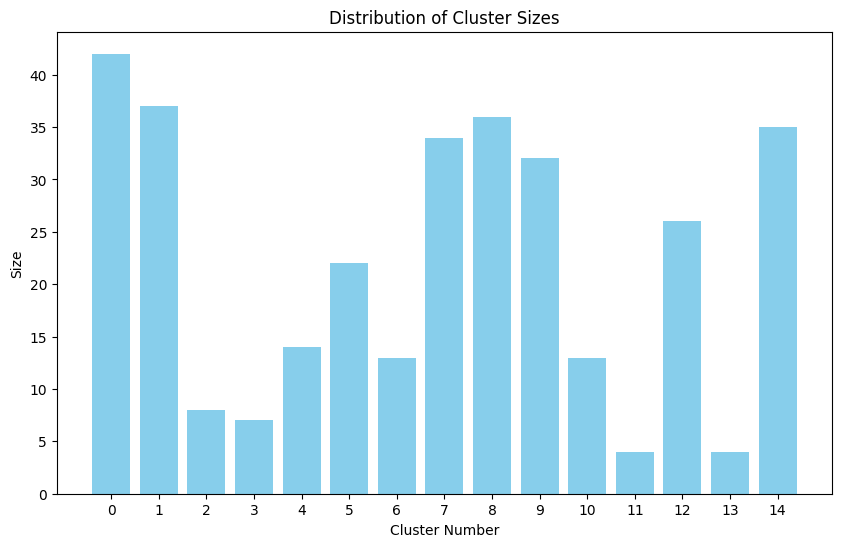

In [9]:
cluster_sizes = Counter(audio['cluster_assignment'])

sorted_cluster_sizes = dict(sorted(cluster_sizes.items()))

total_items = sum(sorted_cluster_sizes.values())
for label, size in sorted_cluster_sizes.items():
    percentage = (size / total_items) * 100
    print(f"Cluster {label}: {size} members ({percentage:.2f}%)")

labels, sizes = zip(*sorted(cluster_sizes.items()))

plt.figure(figsize=(10, 6))
plt.bar(labels, sizes, color='skyblue')
plt.title('Distribution of Cluster Sizes')
plt.xlabel('Cluster Number')
plt.ylabel('Size')
plt.xticks(labels)
plt.show()

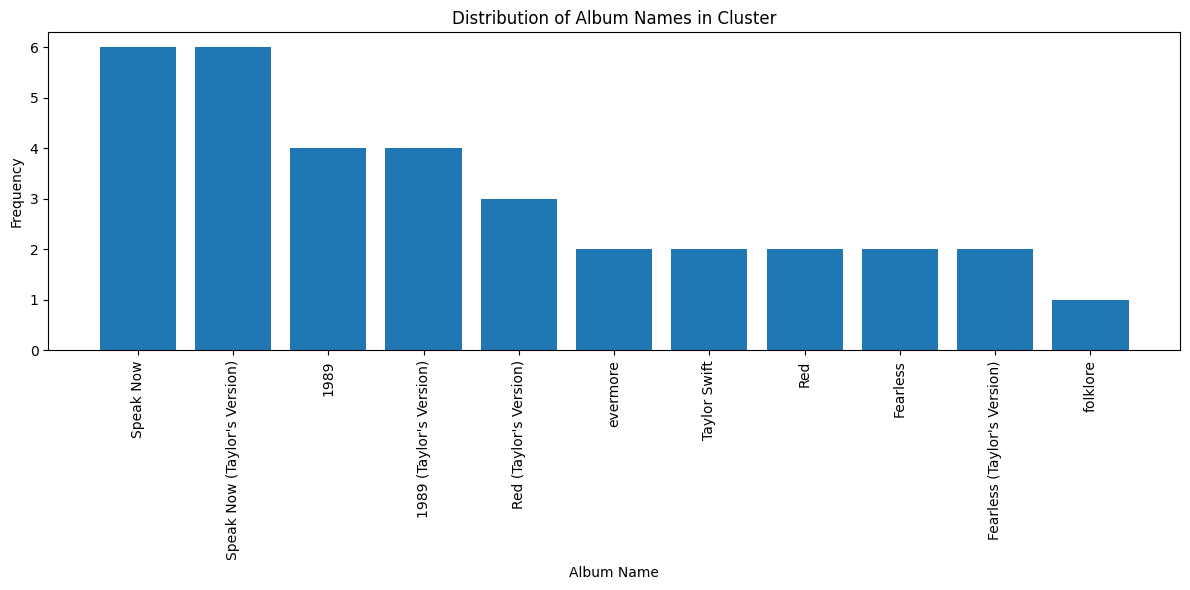

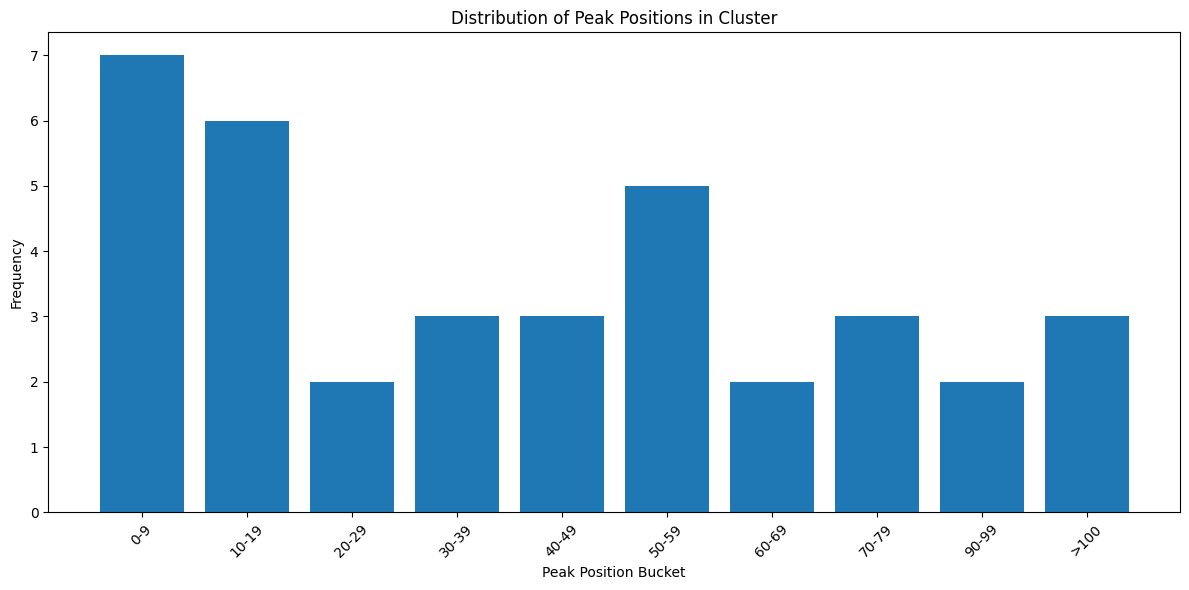

In [10]:
c = 8
cluster = audio[audio["cluster_assignment"] == c].copy()

plt.figure(figsize=(12, 6))
album_name_counts = cluster['album_name'].value_counts()
plt.bar(album_name_counts.index, album_name_counts.values)
plt.xlabel('Album Name')
plt.ylabel('Frequency')
plt.title('Distribution of Album Names in Cluster')
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

plt.figure(figsize=(12, 6))

# Handling NaN values by categorizing them as >100
peak_pos_counts = cluster['peak_pos_bucketed'].value_counts().sort_index()

plt.bar(peak_pos_counts.index, peak_pos_counts.values)
plt.xlabel('Peak Position Bucket')
plt.ylabel('Frequency')
plt.title('Distribution of Peak Positions in Cluster')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

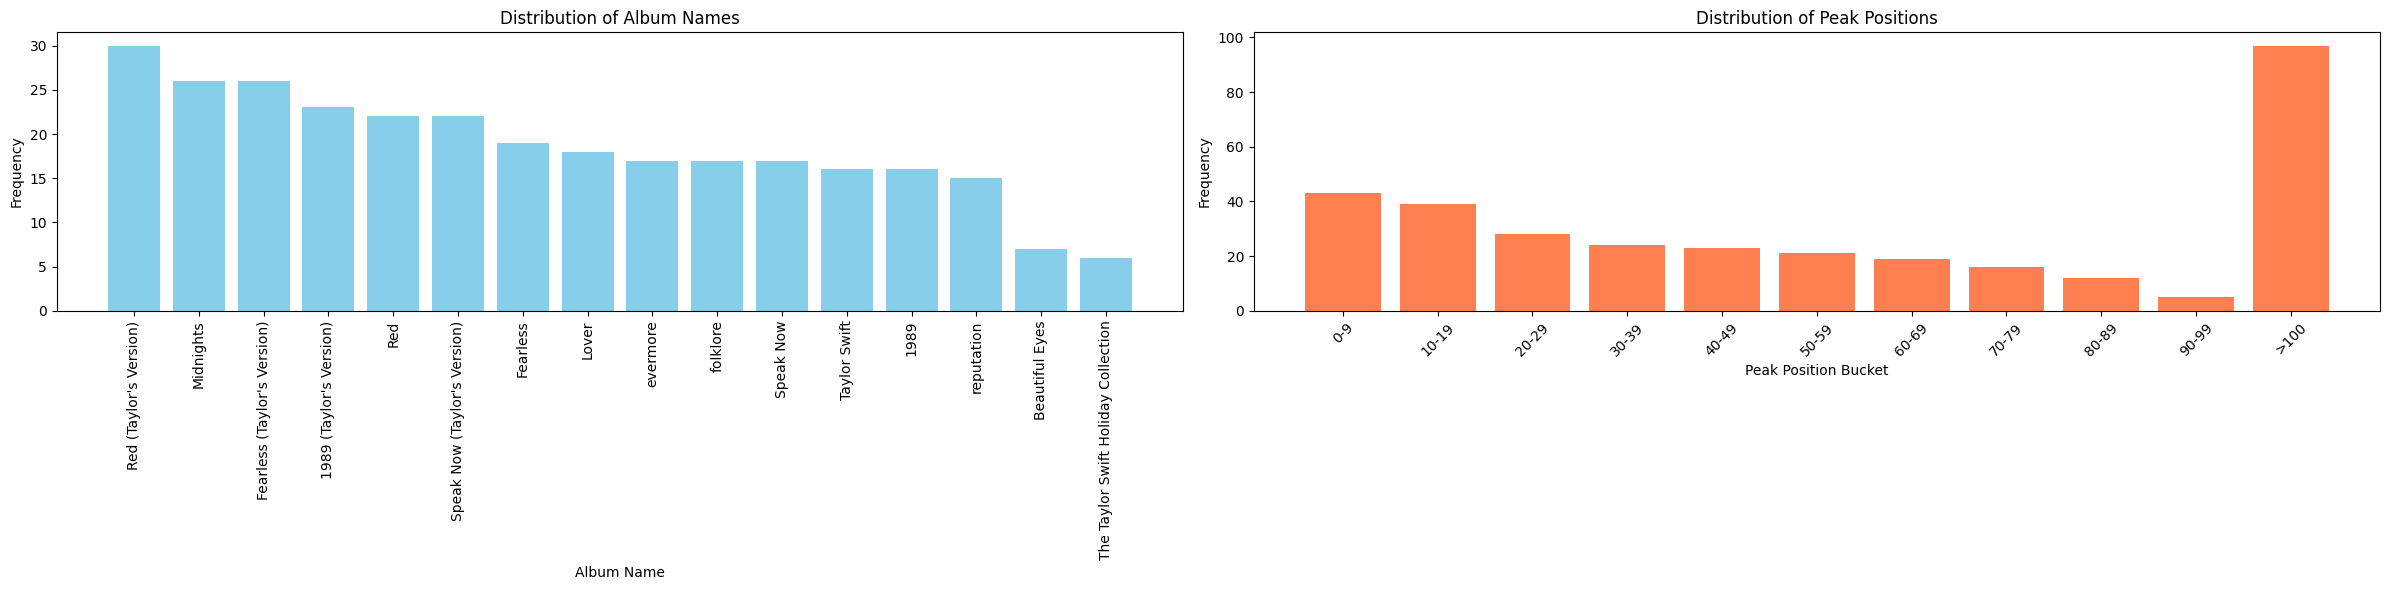

In [11]:
fig, ax = plt.subplots(1, 2, figsize=(24, 6))

# Distribution of Album Names
album_name_counts = audio['album_name'].value_counts()
ax[0].bar(album_name_counts.index, album_name_counts.values, color='skyblue')
ax[0].set_xlabel('Album Name')
ax[0].set_ylabel('Frequency')
ax[0].set_title('Distribution of Album Names')
ax[0].tick_params(axis='x', rotation=90)

# Distribution of Peak Position Buckets
peak_pos_counts = audio['peak_pos_bucketed'].value_counts().sort_index()
ax[1].bar(peak_pos_counts.index, peak_pos_counts.values, color='coral')
ax[1].set_xlabel('Peak Position Bucket')
ax[1].set_ylabel('Frequency')
ax[1].set_title('Distribution of Peak Positions')
ax[1].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

In [12]:
audio['latent_audio'] = audio['latent_audio'].apply(lambda x: [t.item() for t in x] if x != None else None)
audio.to_csv("../data/audio.csv", index=False)